# Data Prep - Destinations and Districts
Organizing destinations for the Pakistan spatial accessibility work and cleaning up district shapefiles

In [1]:
import os, sys, time

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio

import shapely
from shapely.geometry import Point

/Users/robert/.pyenv/versions/geo/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Setup

In [2]:
geo_pth = r"/Users/robert/Documents/Jobs/WB/Pakistan/Data"
pop_pth = r"/Users/robert/Documents/Jobs/WB/Pakistan/Data/Population"
data_pth = r'../../data/vect_out'

In [3]:
health = 'Health/Pakistan_Health_Facilities.shp'
educ = 'Education/KP_Schools_Merge_Final.gpkg'
educ_fata = 'Education/FATA_Schools.gpkg'
mkts = 'Markets/210817_markets.csv'

In [4]:
health = gpd.read_file(os.path.join(geo_pth,health))
educ = gpd.read_file(os.path.join(geo_pth,educ),driver="GPKG")
educ_fata = gpd.read_file(os.path.join(geo_pth,educ_fata),driver="GPKG")
mkts = gpd.GeoDataFrame(pd.read_csv(os.path.join(geo_pth,mkts)))

/Users/robert/.pyenv/versions/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [5]:
dest_crs = 32642

Load in OCHA admin data

In [6]:
adm3 = gpd.read_file(os.path.join(geo_pth,r'Boundaries/OCHA/pak_admbnda_adm3_ocha_pco_gaul_20181218.shp'))

## Education

Cleanup

In [7]:
# align column names
educ.rename({'SchoolLeve' : 'School_Level','SchoolGend':'Gender'},axis=1,inplace=True)
educ_fata.rename({'Level' : 'FATA_Level','CmpID':'FATA_SCode','Institutio':'Institution_Code','Institut_1':'Name'},axis=1,inplace=True)

In [8]:
educ.Gender.unique()

array(['Boys', 'Girls'], dtype=object)

In [9]:
educ.School_Level.unique()

array(['Primary', 'High', 'Middle', 'Higher Secondary'], dtype=object)

In [10]:
from shapely.ops import transform

def _to_2d(x, y, z):
    return tuple(filter(None, [x, y]))

educ['geometry'] = educ['geometry'].apply(lambda x: shapely.ops.transform(_to_2d, x))

Look at data

In [11]:
educ.head(3)

,Name,Scode,SchoolName,PresentSta,Gender,School_Level,GeoLocatio,Village,PostOffice,UnionCounc,...,OtherRooms,Water,Electicity,LatrineUsa,BoudaryWal,X,Y,layer,path,geometry
0,GPS AMBER BANDA,16371,GPS AMBER BANDA,Functional,Boys,Primary,Urban,AMBAR BANDA,NASRAT KHEL,NASRAT KHEL,...,0,Yes,No,2,Yes,71.380217,33.582918,None,None,POINT (71.38022 33.58292)
1,GPS BEHZADI RAILWAY KOHAT,16372,GPS BEHZADI RAILWAY KOHAT,Functional,Boys,Primary,Urban,BEHZADI RAILWAY KOHAT,BEHZADI,URBAN -I,...,1,Yes,Yes,6,Yes,71.4509,33.5725,None,None,POINT (71.45090 33.57250)
2,GPS CITY CENTRE,16373,GPS CITY CENTRE,Functional,Boys,Primary,Urban,CITY CENTRE KOHAT,KOHAT,URBAN -I,...,3,Yes,Yes,2,Yes,71.4355,33.5866,None,None,POINT (71.43550 33.58660)


In [12]:
educ_fata.head(3)

,FATA_SCode,Agency_Nam,Institution_Code,Name,Tehsil,Gender,FATA_Level,Altitude,Altitude_S,x,y,geometry
0,1,Bajaur Agency,592,GDC Khar,Khar,Boys,College,835.0,M,71.5438,34.7547,POINT (71.54380 34.75470)
1,2,Bajaur Agency,594,GDC Barkhalozo,Mamund,Boys,College,1023.0,M,71.4051,34.7905,POINT (71.40510 34.79050)
2,3,Bajaur Agency,595,GDC Nawagai,Nawagai,Boys,College,996.0,M,71.3084,34.6695,POINT (71.30840 34.66950)


Re-arrange FATA data to match main data model

In [13]:
educ_fata.FATA_Level.unique()

array(['College', 'Community', 'High', 'Higher Secondary', 'Middle',
       'Mosque', 'Primary', 'Industrial Home Centre', 'Office',
       'VOCATIONAL INSTITUTE'], dtype=object)

In [14]:
prim_dct = dict.fromkeys(['Primary','Mosque','Community'],'Primary')
sec_dct = dict.fromkeys(['Middle'],'Middle')
high_dct = dict.fromkeys(['High','Higher Secondary'],'High')
voc_dct = dict.fromkeys(['VOCATIONAL CENTRE','Industrial Home Centre'],'Vocational')
tert_dct = dict.fromkeys(['College'],'Tertiary')

In [15]:
level_dct = {}

level_dct.update(prim_dct)
level_dct.update(sec_dct)
level_dct.update(high_dct)
level_dct.update(voc_dct)
level_dct.update(tert_dct)

In [16]:
educ_fata['School_Level'] = educ_fata.FATA_Level.map(level_dct).fillna('Other')

In [17]:
educ_fata.School_Level.unique()

array(['Tertiary', 'Primary', 'High', 'Middle', 'Vocational', 'Other'],
      dtype=object)

#### Tabular analysis of educational facilities

In [223]:
educ.head(2)

,Name,Scode,SchoolName,PresentSta,Gender,School_Level,GeoLocatio,Village,PostOffice,UnionCounc,...,Adm3_En,Adm2_Code,Adm3_Code,BG_Ratio,Boys_total,Girls_total,Total_students,Adm3_total_students,student_wt,Gender_Ratio
0,GPS AMBER BANDA,16371,GPS AMBER BANDA,Functional,Boys,Primary,Urban,AMBAR BANDA,NASRAT KHEL,NASRAT KHEL,...,Kohat,PK211,PK21101,0.003253,69509.0,45868.0,115377.0,115377.0,0.001118,0.003253
1,GPS BEHZADI RAILWAY KOHAT,16372,GPS BEHZADI RAILWAY KOHAT,Functional,Boys,Primary,Urban,BEHZADI RAILWAY KOHAT,BEHZADI,URBAN -I,...,Kohat,PK211,PK21101,0.010362,69509.0,45868.0,115377.0,115377.0,0.004412,0.010362


Join in admin info, clean up 

In [165]:
educ = gpd.sjoin(educ,adm3[['geometry','ADM2_EN','ADM3_EN','ADM2_PCODE','ADM3_PCODE']],\
                 op='within',how='left')

In [166]:
educ.rename({'ADM2_EN':'Adm2_En','ADM3_EN':'Adm3_En','ADM2_PCODE':'Adm2_Code','ADM3_PCODE':'Adm3_Code'},axis=1,inplace=True)

In [168]:
educ.Boys = educ.Boys.astype(int).fillna(0)
educ.Girls = educ.Girls.astype(int).fillna(0)

Create a weighting scheme based on total students for each gender classification vs. total in the tehsil

In [224]:
educ['total_students'] = educ['Boys'] + educ['Girls']

In [235]:
educ.groupby(['Adm3_Code','Gender'])['total_students'].sum().unstack()

Gender,Boys,Girls
Adm3_Code,,
PK20101,112489.0,71103.0
PK20201,59350.0,37637.0
PK20202,19356.0,9114.0
PK20301,18709.0,4519.0
PK20302,28523.0,13674.0
...,...,...
PK61802,63.0,NaN
PK62101,239.0,117.0
PK62103,104.0,NaN


In [242]:
student_totals_by_school_gender = educ.groupby(['Adm3_Code','Gender'])['total_students'].sum().unstack().rename({'Boys':'Adm3_boys_school_total','Girls':'Adm3_girls_school_total'},axis=1)

In [243]:
student_totals_by_school_gender

Gender,Adm3_boys_school_total,Adm3_girls_school_total
Adm3_Code,,
PK20101,112489.0,71103.0
PK20201,59350.0,37637.0
PK20202,19356.0,9114.0
PK20301,18709.0,4519.0
PK20302,28523.0,13674.0
...,...,...
PK61802,63.0,NaN
PK62101,239.0,117.0
PK62103,104.0,NaN


In [210]:
# boys_adm3_tot = educ.groupby(['Adm3_Code'])['Boys'].sum().rename('Boys_total')
# girls_adm3_tot = educ.groupby(['Adm3_Code'])['Girls'].sum().rename('Girls_total')
# students_adm3_tot = (boys_adm3_tot + girls_adm3_tot).rename('Adm3_total_students')

In [244]:
# educ = pd.merge(educ,boys_adm3_tot,on='Adm3_Code',how='left')
# educ = pd.merge(educ,girls_adm3_tot,on='Adm3_Code',how='left')
# educ = pd.merge(educ,students_adm3_tot,on='Adm3_Code',how='left')
educ = pd.merge(educ,student_totals_by_school_gender,on='Adm3_Code',how='left')

In [249]:
educ['Gender'] == 'Boys'

0        True
1        True
2        True
3        True
4        True
         ... 
27894    True
27895    True
27896    True
27897    True
27898    True
Name: Gender, Length: 27899, dtype: bool

In [264]:
educ['student_wt'] = np.where(educ.Gender == 'Boys',\
         ((educ['Boys'] + educ['Girls']) / educ['Adm3_boys_school_total']),
        ((educ['Boys'] + educ['Girls']) / educ['Adm3_girls_school_total']))

Now calculate the ratio and weight it by the size of the school within that gender category

In [265]:
educ['Gender_Ratio'] = (educ['Boys'] / educ['Girls']) * educ['student_wt']

Group by tehsil and calculate the student populated-weighted mean ratio. Invert for Girls

In [267]:
educ_gender_ratio = educ[educ['Gender_Ratio'] != np.inf].dropna(axis=0,subset=['BG_Ratio']).groupby(['Adm2_Code','Adm3_En','Adm3_Code','Gender'])['Gender_Ratio'].sum().unstack().reset_index()

In [268]:
educ_gender_ratio.rename({'Boys':'Boys_schools','Girls':'Girls_schools'},axis=1,inplace=True)

In [270]:
educ_gender_ratio['Girls_schools'] = 1 / educ_gender_ratio['Girls_schools']

In [272]:
educ_gender_ratio

Gender,Adm2_Code,Adm3_En,Adm3_Code,Boys_schools,Girls_schools
0,PK201,Abbottabad,PK20101,2.466532,3.349532
1,PK202,Bannu,PK20201,10.995825,61.717757
2,PK202,Domel,PK20202,7.208704,29.551511
3,PK203,Alai,PK20301,5.600795,3.711220
4,PK203,Batagram,PK20302,3.483107,9.983963
...,...,...,...,...,...
78,PK618,Karor Lal Esan,PK61802,1.423077,NaN
79,PK621,Isakhel,PK62101,4.511737,11.079545
80,PK621,Piplan,PK62103,2.586207,NaN
81,PK630,Murree,PK63005,5.617483,NaN


Export

In [271]:
educ_gender_ratio.to_csv(os.path.join(data_pth,'educ_gender_ratio.csv'))

#### Merge

In [18]:
educ_final = gpd.GeoDataFrame(pd.concat([educ,educ_fata],ignore_index=True))

In [19]:
educ_final.reset_index(drop=True,inplace=True)

In [20]:
# convert everything to title case so it's nice and readable

# vectorized version
for column in educ_final.columns:
    if type(column) == str:
        educ_final[column] = educ_final[column].astype(str).str.title()
    else:
        None

# # non-vector version
# educ_final = educ_final.applymap(lambda x: str(x).title() if type(x) == str else x)

/Users/robert/.pyenv/versions/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [21]:
educ_final.head()

,Name,Scode,SchoolName,PresentSta,Gender,School_Level,GeoLocatio,Village,PostOffice,UnionCounc,...,path,geometry,FATA_SCode,Agency_Nam,Institution_Code,FATA_Level,Altitude,Altitude_S,x,y
0,Gps Amber Banda,16371,Gps Amber Banda,Functional,Boys,Primary,Urban,Ambar Banda,Nasrat Khel,Nasrat Khel,...,None,Point (71.3802 33.5829),Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan
1,Gps Behzadi Railway Kohat,16372,Gps Behzadi Railway Kohat,Functional,Boys,Primary,Urban,Behzadi Railway Kohat,Behzadi,Urban -I,...,None,Point (71.4509 33.5725),Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan
2,Gps City Centre,16373,Gps City Centre,Functional,Boys,Primary,Urban,City Centre Kohat,Kohat,Urban -I,...,None,Point (71.4355 33.5866),Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan
3,Gps Dheri Banda No.2,16374,Gps Dheri Banda No.2,Functional,Boys,Primary,Rural,Dheri Banda,Dhoda,Kharmatoo,...,None,Point (71.4951 33.5007),Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan
4,Gps Gul Abad Chorlaki,16375,Gps Gul Abad Chorlaki,Functional,Boys,Primary,Urban,Chorlaki,Chorlaki,Chorlaki,...,None,Point (71.9107 33.5818),Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan


Fixing some issues with the geometry column

In [22]:
# define a function to only return validly loaded geometries

def wkt_loads(x):
    try:
        return shapely.wkt.loads(x)
    except Exception:
        return None
    
# run the function, in the process removing crap geometries
educ_final['geometry'] = educ_final.geometry.apply(wkt_loads)
educ_final = educ_final.dropna(subset=['geometry'])

# # set the geometry column back and calculate new WGS84 Lat/Longs
educ_final = educ_final.set_geometry('geometry')
educ_final['Latitude'] = educ_final.geometry.y
educ_final['Longitude'] = educ_final.geometry.x

# # drop the old lat / longs, which are duplicate column names and thus throw GPKG errors
educ_final.drop(['X','Y','x','y'],axis=1,inplace=True)

#### Dividing up

Some schools are marked as `Boys` or `Girls` but contain populations of both. We are marked these as mixed, then excluding them from the Boys/Girls files

In [25]:
educ_final.Boys = educ_final.Boys.astype(float)
educ_final.Girls = educ_final.Girls.astype(float)

In [26]:
# more flexible definitions of Gender to reflect reality of mixed attendance
# educ_final.GenderAlt = np.where((educ_final.Boys > 0) & (educ_final.Gender == 'Girls'),'Girls_with_boys',educ_final.Gender)
# educ_final.GenderAlt = np.where((educ_final.Girls > 0) & (educ_final.Gender == 'Boys'),'Boys_with_girls',educ_final.Gender)

# for now using the marked gender for a simpler analysis
educ_final.GenderAlt = educ_final.Gender

/Users/robert/.pyenv/versions/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:182: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


In [27]:
mixed_educ = educ_final[educ_final.GenderAlt == 'Mixed']
boys_educ = educ_final[educ_final.GenderAlt == 'Boys']
girls_educ = educ_final[educ_final.GenderAlt == 'Girls']

In [28]:
# # all
# prim_educ = educ_final[educ_final.School_Level == 'Primary']
# mid_educ = educ_final[educ_final.School_Level == 'Middle']
# high_educ = educ_final[educ_final.School_Level.isin(['High','Higher Secondary'])]

# by boys
prim_educ_boys = boys_educ[boys_educ.School_Level == 'Primary']
mid_educ_boys = boys_educ[boys_educ.School_Level == 'Middle']
high_educ_boys = boys_educ[boys_educ.School_Level.isin(['High','Higher Secondary'])]

# by girls
prim_educ_girls = girls_educ[girls_educ.School_Level == 'Primary']
mid_educ_girls = girls_educ[girls_educ.School_Level == 'Middle']
high_educ_girls = girls_educ[girls_educ.School_Level.isin(['High','Higher Secondary'])]

In [29]:
print(len(boys_educ))
print(len(girls_educ))
print(len(mixed_educ))

21111
12431
0


In [31]:
print(len(prim_educ_boys))
print(len(mid_educ_boys))
print(len(high_educ_boys))

print(len(prim_educ_girls))
print(len(mid_educ_girls))
print(len(high_educ_girls))

17462
1785
1822
10381
1156
835


#### Export

In [30]:
# # all

# prim_educ.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_primary.gpkg'),driver='GPKG')
# mid_educ.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_middle.gpkg'),driver='GPKG')
# high_educ.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_high.gpkg'),driver='GPKG')

# boys

prim_educ_boys.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_boys_primary.gpkg'),driver='GPKG')
mid_educ_boys.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_boys_middle.gpkg'),driver='GPKG')
high_educ_boys.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_boys_high.gpkg'),driver='GPKG')

# girls

prim_educ_girls.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_girls_primary.gpkg'),driver='GPKG')
mid_educ_girls.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_girls_middle.gpkg'),driver='GPKG')
high_educ_girls.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_girls_high.gpkg'),driver='GPKG')

In [62]:
boys_educ.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_boys.gpkg'),driver='GPKG')
girls_educ.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_girls.gpkg'),driver='GPKG')
# mixed_educ.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_mixed.gpkg'),driver='GPKG')

In [63]:
educ_final.to_file(os.path.join(geo_pth,'Education/Destinations/KP_education_clean.gpkg'),driver='GPKG')

## Health

In [5]:
health.head()

,OBJECTID,Id,Category,Sub_Cat,Gov_Pvt,Name,Id_No,Class,Beds,Locality,...,Province,Phone,Mobile,Email,Url,Address,Latitude,Longitude,WEBSITE,geometry
0,1,0.0,GENERAL PHYSICIAN,CLINIC,PRIVATE,SHAEEN CLINIC,None,None,-,None,...,KHYBER PAKHTUNKHWA,None,None,None,None,None,34.170730,73.258978,http://www.alhasan.com/,POINT (73.25898 34.17073)
1,2,0.0,GENERAL PHYSICIAN,CLINIC,PRIVATE,BANO CLINIC,None,None,-,None,...,KHYBER PAKHTUNKHWA,None,None,None,None,None,34.169540,73.259008,http://www.alhasan.com/,POINT (73.25901 34.16954)
2,3,0.0,GENERAL PHYSICIAN,CLINIC,PRIVATE,MANGAL POLY CLINIC,None,None,-,None,...,KHYBER PAKHTUNKHWA,None,None,None,None,None,34.157437,73.263336,http://www.alhasan.com/,POINT (73.26334 34.15744)
3,4,0.0,GENERAL PHYSICIAN,CLINIC,PRIVATE,NUSRAT MEHMOOD CLINIC,None,None,-,None,...,KHYBER PAKHTUNKHWA,None,None,None,None,None,34.147857,73.262899,http://www.alhasan.com/,POINT (73.26290 34.14786)
4,5,0.0,GENERAL HOSPITALS,MEDICAL FACILITIES,PRIVATE,ALTAF HOSPITAL,None,None,-,None,...,KHYBER PAKHTUNKHWA,None,None,None,None,None,34.145415,73.218434,http://www.alhasan.com/,POINT (73.21843 34.14542)


See unedited categories lists

In [92]:
health.Category.unique()

array(['GENERAL PHYSICIAN', 'GENERAL HOSPITALS', 'DENTAL CLINIC',
       'MEDICAL STORES', 'HOMEOPATHIC', 'MATERNITY HOME',
       'ROUTINE TEST LABORATORIES', 'VETERINARY', 'SPECIALIST',
       'DIAGNOSTIC CENTRE', 'OPTICS', 'CLINICAL LABORATORIES',
       'BASIC HEALTH UNIT', 'DISTRICT HEADQUARTER HOSPITAL',
       'CHILDREN HOSPITAL', 'DISPENSARY', 'SUB-HEALTH CENTER',
       'MCH CENTRE', 'LEPROSY CENTRE', 'RURAL HEALTH CENTER', 'TB',
       'TEHSIL HEADQUARTER HOSPITAL', 'DAWAKHANA',
       'AGENCY HEADQUARTER HOSPITAL', 'BLOOD BANK', 'AMBULANCE SERVICE',
       'FAMILY WELFARE CENTER', 'URBAN HEALTH CENTRE', 'MORGUE'],
      dtype=object)

In [93]:
health.Sub_Cat.unique()

array(['CLINIC', 'MEDICAL FACILITIES', 'MEDICAL SERVICES', 'BHU', 'DHQ',
       'SHC', 'MCH', 'RHC', 'THQ', 'AHQ', 'FWC', 'UHC'], dtype=object)

Filter down

In [94]:
drop_filter = ['HOMEOPATHIC','DAWAKHANA','MORGUE','AMBULANCE SERVICE','MEDICAL STORES','MATERNITY HOME',\
               'ROUTINE TEST LABORATORIES','CLINICAL LABORATORIES','DENTAL CLINIC','OPTICS','VETERINARY','MORGUE','BLOOD BANK']

In [95]:
health = health[~health.Category.isin(drop_filter)]

In [96]:
health.Category.unique()

array(['GENERAL PHYSICIAN', 'GENERAL HOSPITALS', 'SPECIALIST',
       'DIAGNOSTIC CENTRE', 'BASIC HEALTH UNIT',
       'DISTRICT HEADQUARTER HOSPITAL', 'CHILDREN HOSPITAL', 'DISPENSARY',
       'SUB-HEALTH CENTER', 'MCH CENTRE', 'LEPROSY CENTRE',
       'RURAL HEALTH CENTER', 'TB', 'TEHSIL HEADQUARTER HOSPITAL',
       'AGENCY HEADQUARTER HOSPITAL', 'FAMILY WELFARE CENTER',
       'URBAN HEALTH CENTRE'], dtype=object)

In [97]:
health.Sub_Cat.unique()

array(['CLINIC', 'MEDICAL FACILITIES', 'MEDICAL SERVICES', 'BHU', 'DHQ',
       'SHC', 'MCH', 'RHC', 'THQ', 'AHQ', 'FWC', 'UHC'], dtype=object)

In [88]:
health[health.Sub_Cat == 'MEDICAL FACILITIES'].Category.unique()

array(['GENERAL HOSPITALS', 'CHILDREN HOSPITAL', 'LEPROSY CENTRE', 'TB'],
      dtype=object)

#### Primary / Secondary / Tertiary

Rural Health Centers - RHC, Basic Health Units - BHU, Maternal and Child Health Centers – MCHC, and Dispensaries, Private General Physician clinics, Private Maternal and Child Health Hospitals, Family welfare centers, vertical program centers (if there is any separate center)

In [77]:
# prim_health_filter = ['RHC','BHU',',CH','FWC',]
prim_health_filter = ['GENERAL PHYSICIAN','FAMILY WELFARE CENTER','MCH CENTRE','CHILDREN HOSPITAL',\
                      'BASIC HEALTH UNIT','URBAN HEALTH CENTRE','RURAL HEALTH CENTER','SUB-HEALTH CENTER']

In [78]:
prim_health = health[health.Category.isin(prim_health_filter) == True]

In [79]:
len(prim_health)

10892

Tehsil Headquarter Hospital – THQ, and District Headquarter Hospital - DHQ, Private Multi-specialty Hospitals, Public/Private Diagnostic Centers,

In [42]:
sec_health_filter = ['DIAGNOSTIC CENTRE',\
                     'TEHSIL HEADQUARTER HOSPITAL','DISTRICT HEADQAURTER HOSPITAL','GENERAL HOSPITALS']

In [71]:
sec_health = health[health.Category.isin(sec_health_filter) == True]

In [72]:
len(sec_health)

4073

Teaching Hospitals, Specialized Hospital and any Private Teaching Hospital  

In [80]:
tert_health_filter = ['SPECIALIST','AGENCY HEADQUARTER HOSPITAL']

In [81]:
tert_health = health[health.Category.isin(tert_health_filter) == True]

In [82]:
len(tert_health)

465

#### Private vs. public

In [47]:
health.Gov_Pvt.unique()

array(['PRIVATE', 'GOVERNMENT'], dtype=object)

In [105]:
private_health = health[health['Gov_Pvt'] == 'PRIVATE']
public_health = health[health['Gov_Pvt'] == 'GOVERNMENT']

In [106]:
print(len(private))
print(len(public))

9745
5881


#### Pharamcies / Diagnostic Services

In [98]:
pharms = health[health.Category.isin(['DIAGNOSTIC CENTRE','DISPENSARY'])]

In [126]:
len(pharms)

1616

#### Family centers

In [100]:
family_health = health[health.Category.isin(['MCH CENTRE','FAMILY WELFARE CENTER'])]

In [101]:
len(family_health)

174

#### Tertiary health
This data was prepared separately

In [31]:
tert_health = 'Health/KP_health_tertiary.csv'

In [32]:
tert_health = pd.read_csv(os.path.join(geo_pth,tert_health))
tert_health = gpd.GeoDataFrame(tert_health,geometry=gpd.points_from_xy(tert_health.Longitude, tert_health.Latitude))
tert_health = tert_health.set_crs(4326).dropna()

<AxesSubplot:>

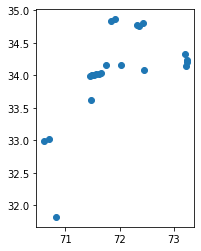

In [33]:
tert_health.plot()

#### Export

In [34]:
# prim_health.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Health/Destinations/KP_health_primary.gpkg'),driver='GPKG')
# sec_health.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Health/Destinations/KP_health_secondary.gpkg'),driver='GPKG')
tert_health.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Health/Destinations/KP_health_tertiary.gpkg'),driver='GPKG')

In [332]:
public_health.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Health/Destinations/KP_health_public.gpkg'),driver='GPKG')
private_health.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Health/Destinations/KP_health_private.gpkg'),driver='GPKG')
pharms.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Health/Destinations/KP_health_pharmacies.gpkg'),driver='GPKG')
family_health.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Health/Destinations/KP_health_family.gpkg'),driver='GPKG')

### Markets

In [417]:
mkts.geometry = gpd.points_from_xy(mkts.Longitude,mkts.Latitude)

In [422]:
mkts = mkts.set_crs(dest_crs)

In [423]:
mkts.head()

,Sl_no,Province,Divison,District,City/town,Address (road),Markets,Type,Weight,Latitude,Longitude,geometry
0,1,Khyber Pakhtunkhwa,Dera Ismail Khan,D I Khan,Dera Ismail Khan,Mustafa Lakhra Road,Nayi Sabzi Mandi Dikhan,NaN,1,31.866451,70.891419,POINT (70.89142 31.86645)
1,2,Khyber Pakhtunkhwa,Hazara,Abbottabad,Abbottabad,N-35 Road,Fruit & Vegetable Market,Central market,3,34.136189,73.207415,POINT (73.20741 34.13619)
2,3,Khyber Pakhtunkhwa,Kohat,Kohat,Kohat,Kohat Road,Kohat Sabzi Mandi,Central market,3,33.587978,71.436807,POINT (71.43681 33.58798)
3,4,Khyber Pakhtunkhwa,Malakand,Swat,Mingora,Madyan Road,Swat Sabzi Mandi,Central market,3,34.781120,72.360524,POINT (72.36052 34.78112)
4,5,Khyber Pakhtunkhwa,Mardan,Mardan,Mardan,Charsadda Road,Sabzi Mandi,Central market,4,34.200557,72.047222,POINT (72.04722 34.20056)


In [424]:
central_mkts = mkts[mkts.Type == 'Central market']

#### Export

In [425]:
mkts.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Markets/Destinations/KP_markets_Agr_All.gpkg'),driver='GPKG')
central_mkts.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Markets/Destinations/KP_markets_Agr_Central.gpkg'),driver='GPKG')

### District centers

Load in and filter down political capitols from the US NGA's GeoNames database

In [6]:
settle = gpd.read_file(os.path.join(geo_pth,'Settlements/KP_Settlements_NGA_2017.gpkg'),driver='GPKG')

/Users/robert/.pyenv/versions/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [7]:
settle.dtypes

FID_Settle     float64
RC              object
UFI            float64
UNI            float64
LAT            float64
LONG           float64
DMS_LAT         object
DMS_LONG        object
MGRS            object
JOG             object
FC              object
DSG             object
PC              object
CC1             object
ADM1            object
POP             object
ELEV            object
CC2             object
NT              object
LC              object
SHORT_FORM      object
GENERIC         object
SORT_NAME_      object
FULL_NAME_      object
FULL_NAME1      object
SORT_NAME1      object
FULL_NAM_1      object
FULL_NAM_2      object
NOTE            object
MODIFY_DAT      object
DISPLAY         object
NAME_RANK      float64
NAME_LINK      float64
TRANSL_CD       object
NM_MODIFY_      object
F_EFCTV_DT      object
F_TERM_DT       object
FID_Pak_ad     float64
PROVINCE        object
PROVINCE_C     float64
DISTRICT        object
DISTRICT_C     float64
TEHSIL          object
TEHSIL_C   

In [8]:
settle.DSG.unique()

array(['STMI', 'CULT', 'LCTY', 'PK', 'STM', 'TRB', 'TRIG', 'MT', 'PPL',
       'AREA', 'FY', 'PASS', 'PPLQ', 'RESF', 'FRST', 'PP', 'MTS', 'RDGE',
       'SHRN', 'RSVT', 'LEV', 'HLL', 'ADM2', 'SPNG', 'FRM', 'RUIN', 'WLL',
       'SCHC', 'FT', 'STMX', 'CNL', 'PPLX', 'CMP', 'HSP', 'PPLA2', 'CMTY',
       'PPLL', 'MSQE', 'STMIX', 'AIRP', 'HLLS', 'AIRF', 'GRVE', 'STMC',
       'BDG', 'RD', 'PLN', 'GROVE', 'SBED', 'GRGE', 'AIRQ', 'PSTP',
       'RSTN', 'RR', 'RHSE', 'MKT', 'SCRP', 'PROM', 'SPUR', 'INSM', 'SLP',
       'LK', 'PSTB', 'TOWR', 'MFG', 'BLDG', 'PNDI', 'GHSE', 'PND', 'CAVE',
       'TMB', 'RSTNQ', 'PPQ', 'STMH', 'LKI', 'STMQ', 'FLLS', 'ML', 'ADM1',
       'PRK', 'MNC', 'RSV', 'CMPQ', 'STMA', 'CLF', 'DAM', 'RVN', 'MNN',
       'BRKS', 'HUT', 'RDIN', 'CMPRF', 'AIRH', 'ADM4', 'VAL', 'ANS',
       'GDN', 'CTRR', 'SCH', 'STDM', 'BLDO', 'HTL', 'RDJCT', 'GATE',
       'SQR', 'ISL', 'CTRB', 'MND', 'STMD', 'FIN', 'SWT', 'PPLA', 'TMPL',
       'COMC', 'PPLW', 'ITTR', 'INDS', 'MLSG', 'CTRM', 

In [9]:
dist_hq = settle[settle.DSG == 'PPLA2']

In [10]:
# GeoNames contains duplicate values for places with alternate names (curiously). We need to drop them
dist_hq = dist_hq[dist_hq.NT == 'N']

In [11]:
len(dist_hq)

25

Some FATA districts + Peshawar are missing from the NGA's list. Let's add them in

In [12]:
missing_district_hqs = [
    
    {'geometry' : Point(69.57223155097161,32.29853374808377),
    'FULL_NAME_' : 'Wanna',
    'DISTRICT' : 'South Waziristan',
    'PROVINCE' : 'Khyber Pakhtunkhwa'
    },
    
    {'geometry' : Point(70.07056927600753,33.00243871750853),
    'FULL_NAME_' : 'Miranshah',
    'DISTRICT' : 'North Waziristan',
    'PROVINCE' : 'Khyber Pakhtunkhwa'
    },
    
    {'geometry' : Point(70.10099866695828,33.901175487256516),
    'FULL_NAME_' : 'Parinchar',
    'DISTRICT' : 'Kurram',
    'PROVINCE' : 'Khyber Pakhtunkhwa'
    },
    
    {'geometry' : Point(70.8539759768257,33.63398814323602),
    'FULL_NAME_' : 'Ghiljo Bazar',
    'DISTRICT' : 'Orakzai',
    'PROVINCE' : 'Khyber Pakhtunkhwa'
    },
    
    {'geometry' : Point(71.40106914331716, 34.323695406621205),
    'FULL_NAME_' : 'Ghalanai',
    'DISTRICT' : 'Mohamand',
    'PROVINCE' : 'Khyber Pakhtunkhwa'
    },
    
    {'geometry' : Point(71.52177558074068,34.73030440088783),
    'FULL_NAME_' : 'Khar',
    'DISTRICT' : 'Bajaur',
    'PROVINCE' : 'Khyber Pakhtunkhwa'
    },
       
    {'geometry' : Point(72.78903960595989,34.613849535640995),
    'FULL_NAME_' : 'Judba',
    'DISTRICT' : 'Tor Ghar',
    'PROVINCE' : 'Khyber Pakhtunkhwa'
    },
    
    {'geometry' : Point(71.54201534829933, 34.013973849282046),
    'FULL_NAME_' : 'Peshawar',
    'DISTRICT' : 'Peshawar',
    'PROVINCE' : 'Khyber Pakhtunkhwa'
    }
]

In [13]:
missing_hqs = gpd.GeoDataFrame(missing_district_hqs)

In [14]:
dist_hq = gpd.GeoDataFrame(pd.concat([dist_hq,missing_hqs],ignore_index=True))

In [15]:
len(dist_hq)

33

#### Export

In [16]:
dist_hq.to_crs(dest_crs).to_file(os.path.join(geo_pth,'Settlements/District_HQs_v2.gpkg'),driver='GPKG')

## Reorganizing admin units

### Preparing districts

The reorganization of KP to include FATA involved merging / splitting quite a few areas. As a result none of the existing shapefiles appear to be 100% accurate. Therefore we need to fix them up

In [276]:
dist_raw = gpd.read_file(os.path.join(geo_pth,'Boundaries/KP_Analysis_Focus_Districts.gpkg'),layer='KP_Analysis_Focus_Districts_4326',driver='GPKG')

/Users/robert/.pyenv/versions/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [277]:
dist_raw.head()

,OBJECTID,PROVINCE,DISTRICT,Shape_Leng,ADMIN_UNIT,Shape_Le_1,Shape_Le_2,Shape_Area,_sum,area_sqkm,pop_density,Revised_District,geometry
0,42,FATA,BAJAUR,1.988338,AGENCY,1.988338,1.988338,0.133810,866640.845123,1359.848834,637.306753,BAJAUR,"MULTIPOLYGON (((71.55699 34.94197, 71.56958 34..."
1,43,FATA,FR BANNU,1.995785,DISTRICT,1.995785,1.995785,0.079323,44720.968910,821.193521,54.458502,BANNU,"MULTIPOLYGON (((70.62797 33.26112, 70.62797 33..."
2,44,FATA,FR D.I.KHAN,2.398188,DISTRICT,2.398188,2.398188,0.158011,55211.743419,1662.258696,33.214892,D I KHAN,"MULTIPOLYGON (((69.97663 31.89880, 69.97699 31..."
3,46,FATA,FR LAKKI MARWAT,0.597855,DISTRICT,0.597855,0.597855,0.017582,12707.589885,182.884176,69.484360,LAKKI MARWAT,"MULTIPOLYGON (((70.40426 32.70648, 70.40447 32..."
4,48,FATA,FR TANK,1.804023,DISTRICT,1.804023,1.804023,0.109871,37077.108184,1145.098977,32.378955,TANK,"MULTIPOLYGON (((70.28373 32.63942, 70.28384 32..."


In [278]:
dist_clean = dist_raw.dissolve(by='Revised_District')

In [279]:
dist_clean = dist_clean.reset_index()

In [280]:
dist_clean = dist_clean.rename({'DISTRICT':'Old_District','Revised_District':'District','PROVINCE':'Province'},axis=1)

In [281]:
# Sloppy capitalized names will catch up with us eventually in visualization
dist_clean.Old_District = dist_clean.Old_District.str.title()
dist_clean.District = dist_clean.District.str.title()
dist_clean.Province = dist_clean.Province.str.title()

In [282]:
dist_clean.head()

,District,geometry,OBJECTID,Province,Old_District,Shape_Leng,ADMIN_UNIT,Shape_Le_1,Shape_Le_2,Shape_Area,_sum,area_sqkm,pop_density
0,Bajaur,"POLYGON ((71.55699 34.94197, 71.56958 34.92076...",42,Fata,Bajaur,1.988338,AGENCY,1.988338,1.988338,0.133810,866640.845123,1359.848834,637.306753
1,Bannu,"POLYGON ((70.38124 32.76709, 70.37976 32.76729...",43,Fata,Fr Bannu,1.995785,DISTRICT,1.995785,1.995785,0.079323,44720.968910,821.193521,54.458502
2,Batagram,"POLYGON ((73.02344 34.58355, 73.02326 34.58358...",65,Khyber Pakhtunkhwa,Batagram,2.051353,DISTRICT,2.051353,2.051353,0.133527,567177.809627,1359.359017,417.239157
3,Chitral,"POLYGON ((73.59401 36.91602, 73.63848 36.91157...",68,Khyber Pakhtunkhwa,Chitral,8.229430,DISTRICT,8.229430,8.229430,1.479200,583789.053115,14775.087759,39.511715
4,D I Khan,"POLYGON ((70.42480 31.24216, 70.42356 31.23983...",44,Fata,Fr D.I.Khan,2.398188,DISTRICT,2.398188,2.398188,0.158011,55211.743419,1662.258696,33.214892


Let's go ahead and calculate the Area (in square KM) in case it's useful later

In [283]:
dist_clean = dist_clean.to_crs(32642)

In [284]:
dist_clean.area_sqkm = round(dist_clean.geometry.area / 1000000,3)

Drop some old columns that are no longer reliable

In [285]:
dist_clean = dist_clean.drop(['OBJECTID','Shape_Leng','Shape_Le_1','Shape_Le_2','Shape_Area','_sum','pop_density'],axis=1)

#### Export

In [286]:
dist_clean.to_crs(32642).to_file(os.path.join(geo_pth,'Boundaries/KP_Analysis_Focus_Districts_Final.gpkg'),layer='Focus_Districts_32642',driver='GPKG')
dist_clean.to_crs(32642).to_file(os.path.join(geo_pth,'Boundaries/KP_Analysis_Focus_Districts_Final.gpkg'),layer='Focus_Districts_32642',driver='GPKG')

### Reorganizing Tehsil data

OCHA seems to have the best tehsil data -- but then also has some inherited data problems from older administrative structures, like Kohistan still being one district

In [334]:
dist_clean = dist_clean.to_crs(4326)

In [335]:
teh_raw = gpd.read_file(os.path.join(geo_pth,'Boundaries/OCHA/pak_admbnda_adm3_ocha_pco_gaul_20181218.shp'))

In [336]:
# Drop some extraneous OCHA columns
teh_raw = teh_raw.drop(['Shape_Leng','Shape_Area','validTo','validOn'],axis=1)

In [337]:
teh_raw.head()

,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,geometry
0,Abbottabad,PK20101,None,None,None,Abbottabad,PK201,Khyber Pakhtunkhwa,PK2,Pakistan,PK,2018-11-30,"POLYGON ((73.46271 34.28738, 73.46965 34.27991..."
1,Ahmadupr East,PK60305,None,None,None,Bahawalpur,PK603,Punjab,PK6,Pakistan,PK,2018-11-30,"POLYGON ((71.23461 29.45480, 71.24380 29.44706..."
2,Ahmedpur Sial,PK61201,None,None,None,Jhang,PK612,Punjab,PK6,Pakistan,PK,2018-11-30,"POLYGON ((72.02826 31.03668, 72.04340 31.03000..."
3,Alai,PK20301,None,None,None,Batagram,PK203,Khyber Pakhtunkhwa,PK2,Pakistan,PK,2018-11-30,"POLYGON ((73.11362 34.92828, 73.14588 34.92708..."
4,Alipur,PK62301,None,None,None,Muzaffargarh,PK623,Punjab,PK6,Pakistan,PK,2018-11-30,"POLYGON ((71.02713 29.48334, 71.02858 29.47463..."


In [338]:
# temporarily set the tehsil geometry to its centroid so you can do a within spatial join operation on the districts
teh_raw['geom_pt'] = teh_raw.geometry.centroid
teh_raw = teh_raw.set_geometry('geom_pt')

<ipython-input-338-d5c05c5b77d2>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  teh_raw['geom_pt'] = teh_raw.geometry.centroid


In [339]:
teh_clean = gpd.sjoin(teh_raw,dist_clean[['District','geometry']],how='left',op='within')

In [340]:
# now get rid of the centroids once more
teh_clean = teh_clean.set_geometry('geometry').drop('geom_pt',axis=1)

Cut out only the tehsils where District info was joined -- which are our focus area tehsils

In [341]:
teh_clean = teh_clean[teh_clean.District.isnull() == False]

#### Export

In [343]:
teh_clean.to_file(os.path.join(geo_pth,'Boundaries/New_Tehsils.gpkg'),driver='GPKG')